In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt

In [63]:
Data = np.loadtxt("data.txt")
Data = Data[np.logical_and(Data[:,101] > 0, Data[:,101] < 1)]
X = np.transpose(Data[:,:100].reshape((-1,10,10)),(0,2,1))
Y1 = Data[:,100]; Y2 = Data[:,101]

In [290]:
Data_var = np.loadtxt("data_var.txt")
vind = np.asarray(Data_var[:,0], dtype=np.int)
Xvar = np.transpose(Data_var[:,1:101].reshape((-1,10,10)),(0,2,1))
Yvar = Data_var[:,101:]
test = []
for i in range(len(vind)):
    if not ind[vind[i]]:
        test.append(i)
len(test), np.sum(np.abs(Xvar - X[vind]))

(211, 0.0)

In [64]:
X[np.random.randint(0,X.shape[0],1)]

array([[[1., 1., 0., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 1., 0., 1., 0.],
        [1., 1., 0., 0., 1., 1., 0., 1., 0., 1.],
        [1., 1., 1., 0., 1., 1., 0., 1., 0., 0.],
        [0., 1., 1., 1., 1., 0., 0., 0., 1., 0.],
        [0., 1., 0., 1., 0., 0., 1., 1., 1., 0.],
        [1., 0., 1., 1., 0., 1., 0., 1., 0., 0.],
        [1., 1., 1., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 1., 0., 1., 1., 0., 1., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0., 1.]]])

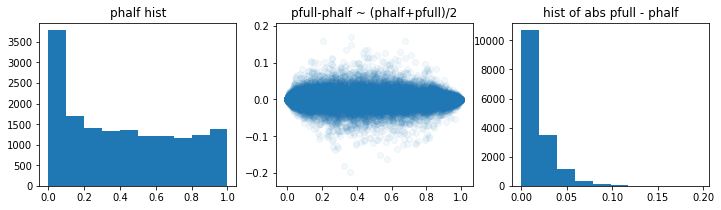

In [262]:
f = plt.figure(figsize=(12,3))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

ax1.hist(Y1)
ax1.title.set_text("phalf hist")

ax2.scatter((Y1+Y2)/2,(Y2-Y1),alpha=0.05)
ax2.title.set_text("pfull-phalf ~ (phalf+pfull)/2")

ax3.hist(np.abs(Y1-Y2))
ax3.title.set_text("hist of abs pfull - phalf")

plt.show()

In [112]:
m = X.shape[1]
XXT2 = (tf.matmul(X, np.transpose(X,(0,2,1))).numpy())**2
S2 = 1/(m*(m-1)) * (np.sum(XXT2,axis=(1,2)) - \
        np.sum(XXT2.reshape((-1,m**2))[:,np.linspace(0,m**2-1,m,dtype=np.int)],axis=1))
S2 = S2.reshape([-1,1])

SS = np.concatenate([np.sum(X,axis=1),np.sum(X,axis=2),S2],axis=1)
SS.shape

(15780, 21)

In [248]:
ind = np.random.binomial(1,0.8,size=X.shape[0]) == 1
# Xtrain = X[ind,:,:].reshape((-1,100)); Ytrain = np.clip(Y1[ind],1e-10,1-1e-10)
# Xtest = X[np.logical_not(ind),:,:].reshape((-1,100)); Ytest = np.clip(Y1[np.logical_not(ind)],1e-10,1-1e-10)

# Xtrain = SS[ind,:]; Ytrain = np.clip(Y1[ind],1e-10,1-1e-10)
# Xtest = SS[np.logical_not(ind),:]; Ytest = np.clip(Y1[np.logical_not(ind)],1e-10,1-1e-10)

Xtrain = X[ind,:,:].reshape((-1,10,10,1)); Ytrain = np.clip(Y1[ind],1e-8,1-1e-8)
Xtest = X[np.logical_not(ind),:,:].reshape((-1,10,10,1)); Ytest = np.clip(Y1[np.logical_not(ind)],1e-8,1-1e-8)
Xtrain.shape, Ytrain.shape, Xtest.shape, X.shape

((12621, 10, 10, 1), (12621,), (3159, 10, 10, 1), (15780, 10, 10))

In [249]:
tf.keras.backend.clear_session()

dim = 10; dr = 0.2
model = keras.Sequential([
            layers.Conv2D(128, (5,5), activation='relu', padding='same', input_shape=(dim,dim,1)),
            layers.Conv2D(64, (5,5), activation='relu', padding='same'),
            layers.MaxPool2D((2,2)),
            layers.Dropout(dr),
            layers.Conv2D(64, (2,2), activation='relu'),
            layers.MaxPool2D((2,2)),
            layers.Flatten(),
            layers.BatchNormalization(),
            layers.Dense(1024, activation='relu'),
            layers.Dropout(dr),
            layers.Dense(256, activation='relu'),
            layers.Dense(1)
        ])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3),
              loss='mse')
# mse; binary_crossentropy; kullback_leibler_divergence
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 10, 128)       3328      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        204864    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          16448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

In [250]:
model.fit(Xtrain,-np.log(1/Ytrain-1), validation_split=0.2,
          batch_size=2048, epochs=512)
# model.fit(Xtrain, -np.log(1/Ytrain-1), validation_split=0.2,
#           batch_size=4096, epochs=128)

Train on 10096 samples, validate on 2525 samples
Epoch 1/512
10096/10096 [==============================] - 1s 130us/sample - loss: 11.8167 - val_loss: 3.7458
Epoch 2/512
10096/10096 [==============================] - 0s 35us/sample - loss: 9.4089 - val_loss: 3.6558
Epoch 3/512
10096/10096 [==============================] - 0s 36us/sample - loss: 8.0490 - val_loss: 3.6887
Epoch 4/512
10096/10096 [==============================] - 0s 34us/sample - loss: 7.0688 - val_loss: 3.7144
Epoch 5/512
10096/10096 [==============================] - 0s 34us/sample - loss: 6.7821 - val_loss: 3.6833
Epoch 6/512
10096/10096 [==============================] - 0s 33us/sample - loss: 6.1696 - val_loss: 3.6784
Epoch 7/512
10096/10096 [==============================] - 0s 33us/sample - loss: 5.7573 - val_loss: 3.6312
Epoch 8/512
10096/10096 [==============================] - 0s 33us/sample - loss: 5.2381 - val_loss: 3.6418
Epoch 9/512
10096/10096 [==============================] - 0s 33us/sample - loss: 4.8

Epoch 76/512
10096/10096 [==============================] - 0s 36us/sample - loss: 0.5179 - val_loss: 3.0485
Epoch 77/512
10096/10096 [==============================] - 0s 37us/sample - loss: 0.5141 - val_loss: 3.0322
Epoch 78/512
10096/10096 [==============================] - 0s 38us/sample - loss: 0.5208 - val_loss: 3.0303
Epoch 79/512
10096/10096 [==============================] - 0s 39us/sample - loss: 0.4779 - val_loss: 3.0746
Epoch 80/512
10096/10096 [==============================] - 0s 38us/sample - loss: 0.4919 - val_loss: 2.9520
Epoch 81/512
10096/10096 [==============================] - 0s 39us/sample - loss: 0.5065 - val_loss: 2.9672
Epoch 82/512
10096/10096 [==============================] - 0s 38us/sample - loss: 0.4939 - val_loss: 3.0130
Epoch 83/512
10096/10096 [==============================] - 0s 38us/sample - loss: 0.5024 - val_loss: 2.8785
Epoch 84/512
10096/10096 [==============================] - 0s 38us/sample - loss: 0.5562 - val_loss: 2.8895
Epoch 85/512
10096/

10096/10096 [==============================] - 0s 39us/sample - loss: 0.2190 - val_loss: 1.8220
Epoch 225/512
10096/10096 [==============================] - 0s 38us/sample - loss: 0.2134 - val_loss: 1.8386
Epoch 226/512
10096/10096 [==============================] - 0s 38us/sample - loss: 0.2158 - val_loss: 1.8151
Epoch 227/512
10096/10096 [==============================] - 0s 38us/sample - loss: 0.2285 - val_loss: 1.9236
Epoch 228/512
10096/10096 [==============================] - 0s 38us/sample - loss: 0.2258 - val_loss: 1.9585
Epoch 229/512
10096/10096 [==============================] - 0s 37us/sample - loss: 0.2243 - val_loss: 1.8568
Epoch 230/512
10096/10096 [==============================] - 0s 38us/sample - loss: 0.2226 - val_loss: 1.8782
Epoch 231/512
10096/10096 [==============================] - 0s 39us/sample - loss: 0.2247 - val_loss: 1.7844
Epoch 232/512
10096/10096 [==============================] - 0s 37us/sample - loss: 0.2199 - val_loss: 1.9974
Epoch 233/512
10096/1009

10096/10096 [==============================] - 0s 37us/sample - loss: 0.1593 - val_loss: 1.8024
Epoch 373/512
10096/10096 [==============================] - 0s 38us/sample - loss: 0.1618 - val_loss: 1.8028
Epoch 374/512
10096/10096 [==============================] - 0s 38us/sample - loss: 0.1661 - val_loss: 1.8381
Epoch 375/512
10096/10096 [==============================] - 0s 38us/sample - loss: 0.1558 - val_loss: 1.7825
Epoch 376/512
10096/10096 [==============================] - 0s 39us/sample - loss: 0.1653 - val_loss: 1.8330
Epoch 377/512
10096/10096 [==============================] - 0s 39us/sample - loss: 0.1650 - val_loss: 1.8932
Epoch 378/512
10096/10096 [==============================] - 0s 37us/sample - loss: 0.1710 - val_loss: 1.7755
Epoch 379/512
10096/10096 [==============================] - 0s 39us/sample - loss: 0.1789 - val_loss: 1.7807
Epoch 380/512
10096/10096 [==============================] - 0s 38us/sample - loss: 0.1852 - val_loss: 1.8131
Epoch 381/512
10096/1009

0.921494143716366


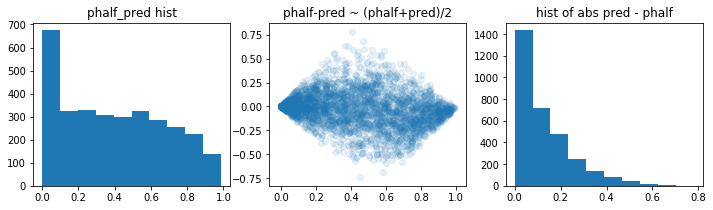

In [261]:
pred = model.predict(Xtest)
pred = pred.reshape((-1,))
pred = 1 / (1 + np.exp(-pred))

print(np.mean((Ytest<0.05) == (pred<0.05)))

f = plt.figure(figsize=(12,3))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

ax1.hist(pred)
ax1.title.set_text("phalf_pred hist")

ax2.scatter((Ytest+pred)/2, (pred-Ytest), alpha = 0.1)
ax2.title.set_text("phalf-pred ~ (phalf+pred)/2")

ax3.hist(np.abs(Ytest-pred))
ax3.title.set_text("hist of abs pred - phalf")

plt.show()

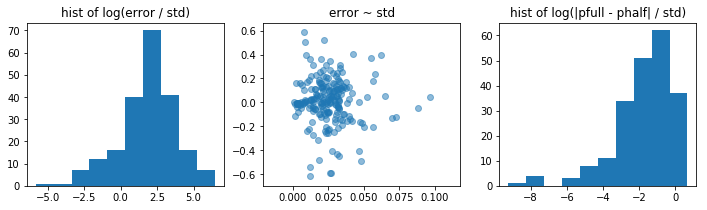

In [294]:
pred_var = model.predict(Xvar.reshape((-1,10,10,1)))
pred_var = pred_var.reshape((-1,))
pred_var = 1 / (1 + np.exp(-pred_var))

f = plt.figure(figsize=(12,3))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

ax1.hist(np.log2(np.abs(np.mean(Yvar[test],axis=1)-pred_var[test]) / np.std(Yvar[test],axis=1)))
ax1.title.set_text("hist of log(error / std)")

ax2.scatter(np.std(Yvar[test],axis=1), np.mean(Yvar[test],axis=1)-pred_var[test], alpha = 0.5)
ax2.title.set_text("error ~ std")

ax3.hist(np.log2(np.abs(Y2[vind[test]]-np.mean(Yvar[test],axis=1)) / np.std(Yvar[test],axis=1)))
ax3.title.set_text("hist of log(|pfull - phalf| / std)")

plt.show()